# Preamble

In [1]:
dir_home = '../'
dir_data = dir_home+'data/'
dir_fig = dir_home+'figs/'
import sys
sys.path.insert(0, dir_home)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from preamble import *
from my_units import *
from signal_functions import *
from param_card_PZT_eta20 import *
import multiprocessing

# Sensitivity

## Fundamental scan

### 4cm

In [2]:
l = 4 * CentiMeter; N_series = 1; N_parallel = 1; 

omega_0 = np.abs(fn_omega_n(l,v,1)); 
omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);

C_c = fn_C_crystal_TE_c(l,a,b,beta_11)
C_1_fid = np.real(C_c)
L_1_fid = 1/(omega_0**2 * np.real(C_c))
print(c_11, h_11, k2, omega_0, omega_res, C_c, C_1_fid, L_1_fid)

t_int = 1 * Year
N_shots = int(1e4)
t_shot = t_int / N_shots
Q_a = (235 / np.sqrt(2) * KiloMeter / Second)**(-2); print('Q_a =',Q_a)

(1.834714445078486e-27+1.8347144450784862e-30j) (1.0943649042090936e-15+0j) (0.6527621513584662-0.0013055256082425408j) 1.1599463157283172e-19 7.959725345855253e-20 (2.027369488089204e+19-2.027369488089204e+16j) 2.027369488089204e+19 3.665990323574772e+18
Q_a = 3254885.2104547503


In [3]:
print(h_tilde,V_c, 150*10**-30 * Meter**3)

(19.999960000039998+0j) 5.935690897699803e+18 1.9530348966841807e+19


In [4]:
vec_L_1 = L_1_fid * np.logspace(-1,2,3000)
vec_C_1 = C_1_fid * np.asarray([0.1,10])
arr_omega_opt = np.ones((len(vec_L_1),len(vec_C_1))) * np.nan; 
L_2 = np.real(L_i)

for i,L_1 in enumerate(vec_L_1):
    L_1_n = L_1 * (1 - 1j * eps_L_1)
    for j,C_1 in enumerate(vec_C_1):
        def fun_Z(omega_frac):
            return np.imag(fn_Z_total(omega_frac * omega_0,l,v,a,b,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1_n, L_2, k_f,N_series,N_parallel))
        if j==0:
            try:
                arr_omega_opt[i,j] = brentq(f=fun_Z,a=(2*omega_res-omega_0)/omega_0,b=(1-1e-5),xtol=1e-12)
            except ValueError:
                pass
        elif j==1:
            try:
                arr_omega_opt[i,j] =  brentq(f=fun_Z,a=1+1e-5,b=(3*omega_0-2*omega_res)/omega_0,xtol=1e-12)
            except ValueError:
                pass
            
fn_L_1_down = interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,0]),0],vec_L_1[np.isfinite(arr_omega_opt[:,0])],bounds_error=False,fill_value=np.nan)
fn_L_1_up = interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,1]),1],vec_L_1[np.isfinite(arr_omega_opt[:,1])],bounds_error=False,fill_value=np.nan)

vec_omega_branch_down = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,0]),np.nanmax(arr_omega_opt[:,0]),int(N_shots/2))
vec_omega_branch_up = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,1]),np.nanmax(arr_omega_opt[:,1]),int(N_shots/2))
vec_omega_plot = np.linspace(3*omega_res-2*omega_0,4*omega_0-3*omega_res,1000)

vec_L_1_branch_down = fn_L_1_down(vec_omega_branch_down)
vec_L_1_branch_up = fn_L_1_up(vec_omega_branch_up)
vec_L_1_branch = np.concatenate([vec_L_1_branch_down,vec_L_1_branch_up])

In [5]:
vec_theta_sens_plot = np.zeros(vec_omega_plot.shape)
for i,L_1 in enumerate(tqdm(vec_L_1_branch)):
    L_1_n = L_1 * (1 - 1j * eps_L_1)
    if i < N_shots//2:
        C_1 = vec_C_1[0]
    else:
        C_1 = vec_C_1[1]
    vec_theta_sens_shot = fn_theta_sens(t_shot,Q_a,T,vec_omega_plot,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid,L_i, k_i,C_1,L_1_n,L_2,k_f,eta, S_flux_squid,
                                        T_2,mu_N,n_N,xi_11,zeta_11,P_nuc,N_series,N_parallel)
    if vec_theta_sens_shot.all() > 0:
        vec_theta_sens_plot += vec_theta_sens_shot**(-4)
    else:
        print(L_2, C_1, L_1, end='')
vec_theta_sens_plot = vec_theta_sens_plot**(-1/4)

100%|██████████| 10000/10000 [00:10<00:00, 997.44it/s]


In [6]:
omega = (omega_res + omega_0)/2
L_1_n = fn_L_1_down(omega) * (1 - 1j * eps_L_1)
C_1 = vec_C_1[0]

In [7]:
np.save(dir_data+'omegafid_pzt.npy', [omega_res,omega_0])
np.save(dir_data+'vec_omega_plot_pzt.npy', vec_omega_plot)
np.save(dir_data+'vec_theta_shot_pzt.npy', vec_theta_sens_shot)
np.save(dir_data+'vec_theta_sens_plot_pzt.npy', vec_theta_sens_plot)

In [8]:
omega_res = np.load(dir_data+'omegafid_pzt.npy')[0]
omega_0 = np.load(dir_data+'omegafid_pzt.npy')[1]
vec_omega_plot = np.load(dir_data+'vec_omega_plot_pzt.npy')
vec_theta_sens_shot = np.load(dir_data+'vec_theta_shot_pzt.npy')
vec_theta_sens_plot = np.load(dir_data+'vec_theta_sens_plot_pzt.npy')

In [9]:
vec_G_aee_sens_shot = vec_theta_sens_shot / ThetaAxion * xi_11 / xi_11_G_aee
vec_G_aee_sens_plot = vec_theta_sens_plot / ThetaAxion * xi_11 / xi_11_G_aee

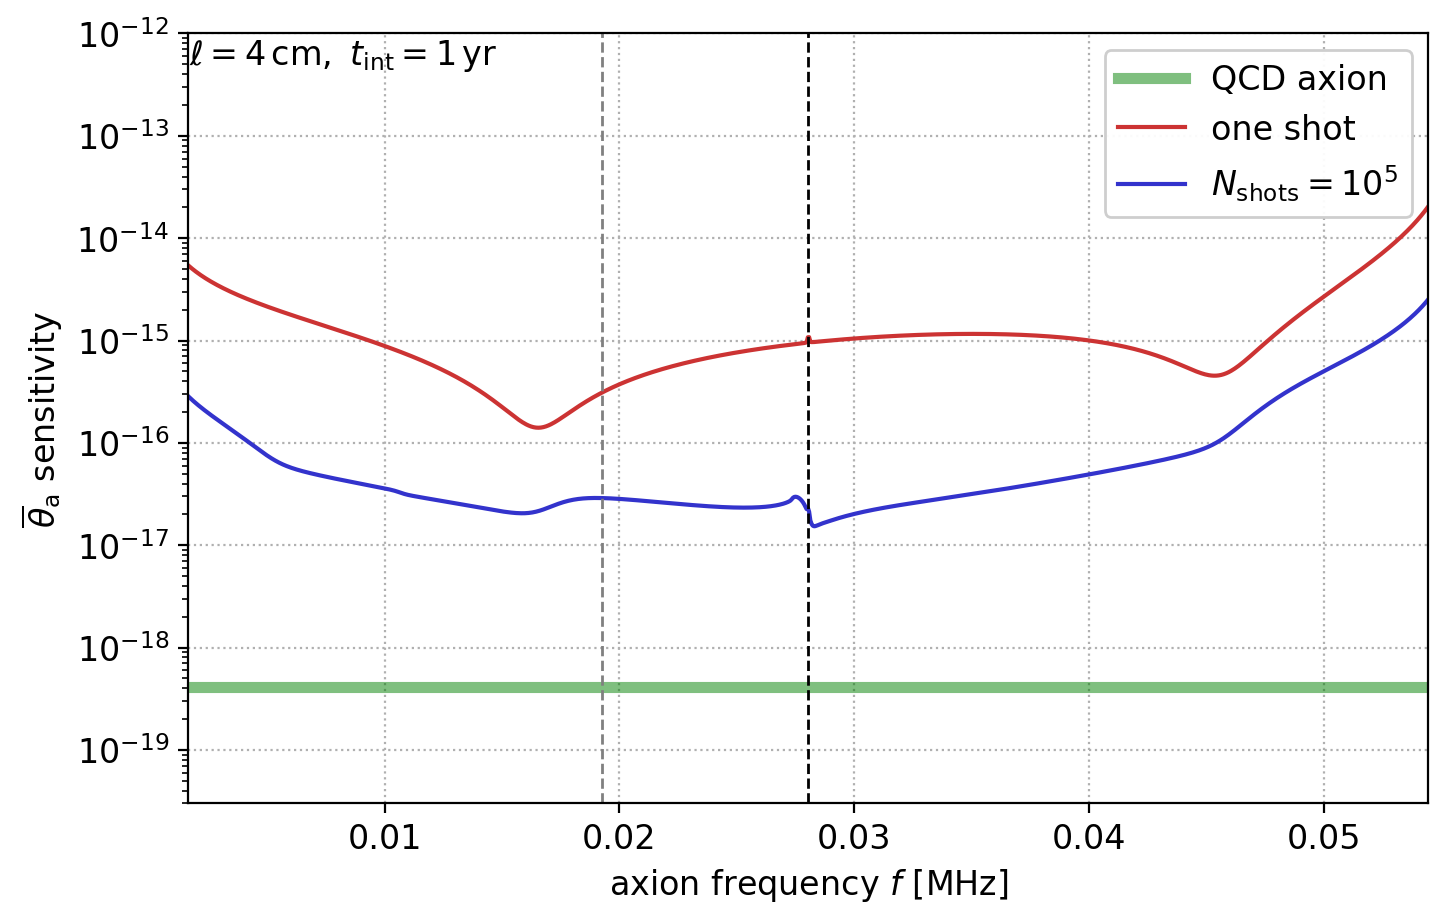

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot([1e-5,1e15],2*[ThetaAxion],color='green',lw=4,alpha=0.5,label='QCD axion')

ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_theta_sens_shot,color=(0.8,0.2,0.2),label='one shot')
ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_theta_sens_plot,color=(0.2,0.2,0.8),label='$N_\mathrm{shots} = 10^5$')
ax.axvline(omega_res/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='gray')
ax.axvline(omega_0/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='black')

#ax.plot(arr_comb[:,0]/(2*np.pi*Second**-1),arr_comb[:,1],lw=2,alpha=1,color='black',label='combined')
#for n in range(1,n_max+1):
    #ax.plot(arr[n-1,:,0]/(2*np.pi*Second**-1),arr[n-1,:,1],lw=1,alpha=0.8,label=r'$n = $'+str(n));
    #ax.axvline(0.95 * fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #anti-resonances
    #ax.axvline(fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #destructive interference
    
ax.set_xscale('linear'); ax.set_yscale('log');
xlim = vec_omega_plot[0]/(2*np.pi*1e6*Second**-1),vec_omega_plot[-1]/(2*np.pi*1e6*Second**-1)
ylim = 3e-20,1e-12
ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.set_xlabel('axion frequency $f ~ [\mathrm{MHz}]$'); ax.set_ylabel(r'$\overline{\theta}_\mathrm{a}$ sensitivity');
ax.grid(ls='dotted');
ax.legend(loc='upper right',ncol=1,framealpha=0.95);
#ax.set_title(r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');
ax.text(xlim[0]*(1.002),ylim[1]*0.5,r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');

In [11]:
arr_comb_hypo_4cm_fund = np.transpose(np.asarray([vec_omega_plot,vec_theta_sens_plot]))

In [12]:
fig.savefig(dir_fig+'sensitivity_QCD_shot_4cm_eta20.pdf', bbox_inches='tight', pad_inches = 0)

/cm/shared/apps/conda-environments/python38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/cm/shared/apps/conda-environments/python38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


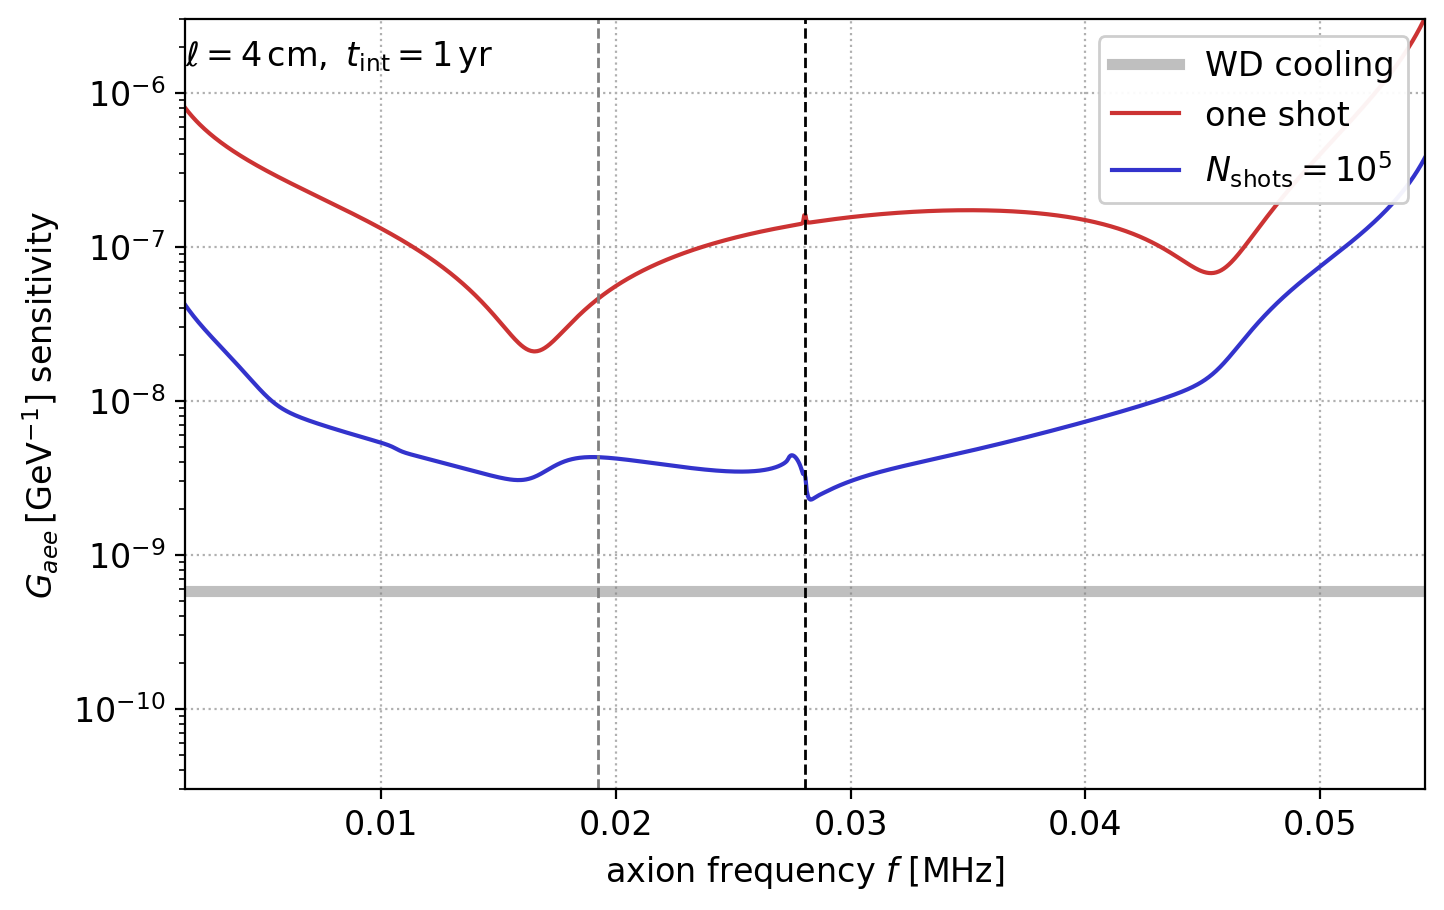

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot([1e-5,1e15],2*[3*1e-13/MElectron * GeV],color='gray',lw=4,alpha=0.5,label='WD cooling')

ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_G_aee_sens_shot,color=(0.8,0.2,0.2),label='one shot')
ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_G_aee_sens_plot,color=(0.2,0.2,0.8),label='$N_\mathrm{shots} = 10^5$')
ax.axvline(omega_res/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='gray')
ax.axvline(omega_0/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='black')

#ax.plot(arr_comb[:,0]/(2*np.pi*Second**-1),arr_comb[:,1],lw=2,alpha=1,color='black',label='combined')
#for n in range(1,n_max+1):
    #ax.plot(arr[n-1,:,0]/(2*np.pi*Second**-1),arr[n-1,:,1],lw=1,alpha=0.8,label=r'$n = $'+str(n));
    #ax.axvline(0.95 * fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #anti-resonances
    #ax.axvline(fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #destructive interference
    
ax.set_xscale('linear'); ax.set_yscale('log');
xlim = vec_omega_plot[0]/(2*np.pi*1e6*Second**-1),vec_omega_plot[-1]/(2*np.pi*1e6*Second**-1)
ylim = 3e-11,3e-6
ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.set_xlabel('axion frequency $f ~ [\mathrm{MHz}]$'); ax.set_ylabel(r'$G_{aee} \, [\mathrm{GeV^{-1}}]$ sensitivity');
ax.grid(ls='dotted');
ax.legend(loc='upper right',ncol=1,framealpha=0.95);
#ax.set_title(r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');
ax.text(xlim[0]*(1.002),ylim[1]*0.5,r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');

In [14]:
fn_omega_n([2*CentiMeter, 4*CentiMeter],v,1)


array([2.31989263e-19, 1.15994632e-19])

In [15]:
fn_omega_res([2*CentiMeter, 4*CentiMeter],v,h_11,c_11,beta_11)

array([1.59194507e-19, 7.95972535e-20])

## Ultimate (eta = 1)

In [16]:
vec_l = np.asarray([40.*CentiMeter,4.*CentiMeter,0.40*CentiMeter,0.01*CentiMeter])
vec_aspect = np.asarray([np.sqrt(0.1),10,20,100])
vec_N_series = np.asarray([1,1,64,256])
vec_N_parallel = np.asarray([1,1,1,32])
vec_M = rho * vec_l**3 * vec_aspect**2 * vec_N_series * vec_N_parallel
print('masses =',vec_M/Kg, 'kilograms')
print([int(i) for i in vec_N_series*vec_N_parallel])

masses = [48.64     48.64     12.45184   0.622592] kilograms
[1, 1, 64, 8192]


In [17]:
t_int = 10 * Year #scanning time per octave
N_shots = 10**5 #number of shots per octave
t_shot = t_int / N_shots 
Q_a = (235 / np.sqrt(2) * KiloMeter / Second)**(-2);

In [18]:
vec_omega_opt_q = np.zeros(len(vec_l))
vec_band_frac_q = np.zeros(len(vec_l))
vec_S_opt_q = np.zeros(len(vec_l))
vec_theta_sens_piezo_q = np.zeros(len(vec_l))
vec_theta_sens_electro_q = np.zeros(len(vec_l))
L_2 = 10*np.real(L_i)

for i_l,l in enumerate(vec_l):
    aspect = vec_aspect[i_l]; a = aspect; b = aspect; 
    N_series = float(vec_N_series[i_l])
    N_parallel = float(vec_N_parallel[i_l])
    omega_0 = np.abs(fn_omega_n(l,v,1));
    omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);
    C_c = N_series**(-1) * N_parallel * fn_C_crystal_TE_c(l,a,b,beta_11)
    L_1_fid = 1/(omega_0**2 * np.real(C_c))
    C_1_fid = np.real(C_c)
    C_1 = 0.1*C_1_fid;
    L_1 = 10*L_1_fid * (1 - 1j * eps_L_1);
    #L_2 = L2_find(T, l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, k_f, 1, S_flux_squid, T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel,0)[0]
    def fun_Z(omega_frac):
        return np.imag(fn_Z_total(omega_frac * omega_0,l,v,a,b,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, N_series,N_parallel))
    def fun_S(omega_frac):
        return fn_S_theta(T,omega_frac * omega_0,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, 1,S_flux_squid,
                          T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel)
    def fun_S_bandwidth(omega_frac,omega_opt):
        return fun_S(omega_frac)/fun_S(omega_opt)-2
    try:
        omega_frac_q = brentq(f=fun_Z,a=(3*omega_res-2*omega_0)/omega_0,b=(1-1e-2),xtol=1e-15)
        vec_omega_opt_q[i_l] = omega_0 * omega_frac_q
        vec_S_opt_q[i_l] = fun_S(omega_frac_q)
        #omega_frac_1_q = brentq(f=fun_S_bandwidth,a=omega_frac_q*(1-1e-1),b=omega_frac_q,xtol=1e-15,args=(omega_frac_q))
        #omega_frac_2_q = brentq(f=fun_S_bandwidth,a=omega_frac_q,b=omega_frac_q*(1+1e-1),xtol=1e-15,args=(omega_frac_q))
        #vec_band_frac_q[i_l] = (omega_frac_2_q - omega_frac_1_q)/omega_frac_q
        t_shot = t_int
        vec_theta_sens_piezo_q[i_l] = fn_theta_sens(t_shot,Q_a,T,vec_omega_opt_q[i_l],l,v,a,b,h_11,c_11,beta_11,k2,L_squid,R_squid,L_i, k_i,C_1,L_1,L_2,k_f,1,S_flux_squid, 
                                                  T_2,mu_N,n_N,xi_11,zeta_11,P_nuc,N_series,N_parallel)
        vec_theta_sens_electro_q[i_l] = fn_theta_sens(t_shot,Q_a,T,vec_omega_opt_q[i_l],l,v,a,b,h_11,c_11,beta_11,k2,L_squid,R_squid,L_i, k_i,C_1,L_1,L_2,k_f,1,S_flux_squid, 
                                                    T_2,mu_N,n_N,0*xi_11,zeta_11,P_nuc,N_series,N_parallel)

    except RuntimeWarning:
        print('err')
        pass
    #print('[l/cm, mass/kg, C_1/picoFarad, L_1/milliHenry, omega_frac] =', 
    #[str(l/CentiMeter)[0:6], str(vec_M[i_l]/Kg)[0:6], str(C_1/(1e-12*Farad))[0:6],str(L_1/(1e-3*Henry))[0:6])

In [19]:
vec_G_aee_sens_piezo_q = vec_theta_sens_piezo_q / ThetaAxion * xi_11 / xi_11_G_aee
vec_G_aee_sens_electro_q = vec_theta_sens_electro_q / ThetaAxion * xi_11 / xi_11_G_aee

In [20]:
print(np.sqrt(vec_S_opt_q[:]/(ThetaAxion**2 / Hz)) )
print(vec_theta_sens_piezo_q/ThetaAxion)
print(vec_theta_sens_electro_q/ThetaAxion)
print(vec_band_frac_q)
print(vec_omega_opt_q/(2*np.pi*1e3*Hz))

[19696.93344859  6236.39978346  3945.44902144  3990.25214275]
[25.05390315 14.10622233 15.86986429 40.36380636]
[1004427.26219821  565527.62215798  636233.17485112 1618211.23191613]
[0. 0. 0. 0.]
[2.68688693e+00 2.68688693e+01 2.68688693e+02 1.07475477e+04]


In [21]:
arr_sens_ultimate_q = np.transpose([vec_omega_opt_q,vec_theta_sens_piezo_q,vec_theta_sens_electro_q])
arr_sens_ultimate_G_aee_q = np.transpose([vec_omega_opt_q,vec_G_aee_sens_piezo_q,vec_G_aee_sens_electro_q])

In [22]:
np.save(dir_data+'sens_ultimate_PZT.npy', arr_sens_ultimate_q)
np.save(dir_data+'sens_ultimate_G_aee_PZT.npy', arr_sens_ultimate_G_aee_q)